# Convolutional Neural Networks
This notebook will guide you through the use of the `keras` package to train convolutional neural networks for handwritten digits classification. You are going to use the `mnist` dataset from LeCun et al. 1998.

## Loading the packages

In [134]:
# masquer les warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('absl').setLevel(logging.ERROR)


In [135]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as pl

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
from sklearn import metrics as me
from scipy import stats
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

In [136]:
import sys
import re

class FilteredStderr:
    def __init__(self, original):
        self.original = original

    def write(self, msg):
        if re.search(r"ptx85", msg):
            return
        self.original.write(msg)

    def flush(self):
        self.original.flush()

sys.stderr = FilteredStderr(sys.stderr)


First, create some useful functions

In [137]:
def build_grid_of_images(array):
    assert len(array.shape) == 3
    dim_0 = np.sqrt(array.shape[0])
    assert dim_0.is_integer()
    
    temp_out = np.reshape(array, (dim_0, dim_0, array.shape[1], array.shape[2]))
    temp_out = np.rollaxis(temp_out, 1, 3)
    return np.reshape(temp_out, (dim_0*array.shape[1], dim_0*array.shape[2]))

def plot_conv_layer_output(temp_out, title):
    temp_to_plot = build_grid_of_images(temp_out)
    pl.imshow(temp_to_plot, interpolation='nearest', cmap=pl.get_cmap('Greys'))
    ax = pl.gca()
    ax.set_xticks(np.arange(-0.5, temp_to_plot.shape[0]+0.5, temp_out.shape[1]))    
    ax.set_yticks(np.arange(-0.5, temp_to_plot.shape[0]+0.5, temp_out.shape[2]))
    pl.grid()
    pl.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
    pl.title(title)

def plot_dense_layer_output(temp_out, title):
    pl.bar(np.arange(temp_out.shape[1])-0.4, temp_out[0,:])
    pl.xlim(-0.5, temp_out.shape[1])
    pl.grid()
    pl.title(title)

Load the `mnist` dataset and normalize in the range [0, 1]

In [138]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Split the training set into a training set and a validation set
X_val = X_train[0:10000,:,:]
X_train = X_train[10000:,:,:]
y_val = y_train[0:10000]
y_train = y_train[10000:]

n_train, height, width = X_train.shape
n_val, _, _ = X_val.shape
n_test, _, _ = X_test.shape

X_train = X_train.reshape(n_train, height, width, 1).astype('float32')
X_val = X_val.reshape(n_val, height, width, 1).astype('float32')
X_test = X_test.reshape(n_test, height, width, 1).astype('float32')

X_train /= 255.0
X_val /= 255.0
X_test /= 255.0

n_classes = 10

print(n_train, 'train samples')
print(n_val, 'validation samples')
print(n_test, 'test samples')

# convert class vectors to binary class matrices
Y_train = tf.keras.utils.to_categorical(y_train, n_classes)
Y_val = tf.keras.utils.to_categorical(y_val, n_classes)
Y_test = tf.keras.utils.to_categorical(y_test, n_classes)

50000 train samples
10000 validation samples
10000 test samples


Create the CNN and show its architecture

In [139]:
l0 = Input(shape=(height, width, 1), name='l0')

l1 = Conv2D(32, (3, 3), padding='same', activation='relu', name='l1')(l0)
l1_mp = MaxPooling2D(pool_size=(2, 2), name='l1_mp')(l1)

l2 = Conv2D(64, (3, 3), padding='same', activation='relu', name='l2')(l1_mp)
l2_mp = MaxPooling2D(pool_size=(2, 2), name='l2_mp')(l2)

l3 = Conv2D(128, (3, 3), padding='same', activation='relu', name='l3')(l2_mp)
l3_mp = MaxPooling2D(pool_size=(2, 2), name='l3_mp')(l3)

flat = Flatten(name='flat')(l3_mp)

drop1 = Dropout(0.3, name='drop1')(flat)

l4 = Dense(25, activation='relu', name='l4')(drop1)

drop2 = Dropout(0.3, name='drop2')(l4)

l5 = Dense(n_classes, activation='softmax', name='l5')(drop2)

model = Model(inputs=l0, outputs=l5)
model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 l0 (InputLayer)             [(None, 28, 28, 1)]       0         
                                                                 
 l1 (Conv2D)                 (None, 28, 28, 32)        320       
                                                                 
 l1_mp (MaxPooling2D)        (None, 14, 14, 32)        0         
                                                                 
 l2 (Conv2D)                 (None, 14, 14, 64)        18496     
                                                                 
 l2_mp (MaxPooling2D)        (None, 7, 7, 64)          0         
                                                                 
 l3 (Conv2D)                 (None, 7, 7, 128)         73856     
                                                                 
 l3_mp (MaxPooling2D)        (None, 3, 3, 128)         0  

Define some constants and train de CNN. In order to perform the model selection process, you train each model with the train dataset and evaluate it with the validation dataset. The test set remains unseen.

In [140]:
batch_size = 256
n_epoch = 50

model.compile(loss='categorical_crossentropy', optimizer=SGD(momentum=0.9), metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epoch, verbose=1, validation_data=(X_val, Y_val))

Epoch 1/50
196/196 [==============================] - 3s 11ms/step - loss: 1.3124 - accuracy: 0.5524 - val_loss: 0.2216 - val_accuracy: 0.9408
Epoch 2/50
196/196 [==============================] - 2s 9ms/step - loss: 0.3350 - accuracy: 0.8964 - val_loss: 0.1265 - val_accuracy: 0.9671
Epoch 3/50
196/196 [==============================] - 2s 10ms/step - loss: 0.2354 - accuracy: 0.9291 - val_loss: 0.0989 - val_accuracy: 0.9714
Epoch 4/50
196/196 [==============================] - 2s 9ms/step - loss: 0.1884 - accuracy: 0.9443 - val_loss: 0.0887 - val_accuracy: 0.9739
Epoch 5/50
196/196 [==============================] - 2s 9ms/step - loss: 0.1657 - accuracy: 0.9504 - val_loss: 0.0734 - val_accuracy: 0.9794
Epoch 6/50
196/196 [==============================] - 2s 10ms/step - loss: 0.1404 - accuracy: 0.9579 - val_loss: 0.0724 - val_accuracy: 0.9799
Epoch 7/50
196/196 [==============================] - 2s 9ms/step - loss: 0.1289 - accuracy: 0.9619 - val_loss: 0.0708 - val_accuracy: 0.9810
Epo

Show the performance of the model. By observing the performance of your models on the validation set, you will choose a set of hyperparameters for your final model. The test set is still not used at this point.

Validation score: 0.040316950529813766
Validation accuracy: 0.9911999702453613


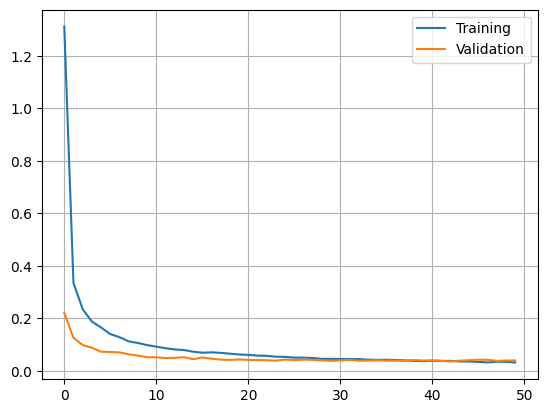

In [141]:
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Validation')
pl.legend()
pl.grid()

score = model.evaluate(X_val, Y_val, verbose=0)
print('Validation score:', score[0])
print('Validation accuracy:', score[1])

Now that you have chosen your final model, you can finally evaluate its performance using the test set. It is important that the test set remains hidden for your model until this last step in order to have an unbiased estimate of the performance. Therefore, you should not run the following cell until you have chosen your final model.

In [142]:
final_score = model.evaluate(X_test, Y_test, verbose=0)
print('FINAL RESULTS:')
print('Test score:', final_score[0])
print('Test accuracy:', final_score[1])

FINAL RESULTS:
Test score: 0.021214492619037628
Test accuracy: 0.9937999844551086


Confusion matrix

313/313 [==============================] - 1s 3ms/step


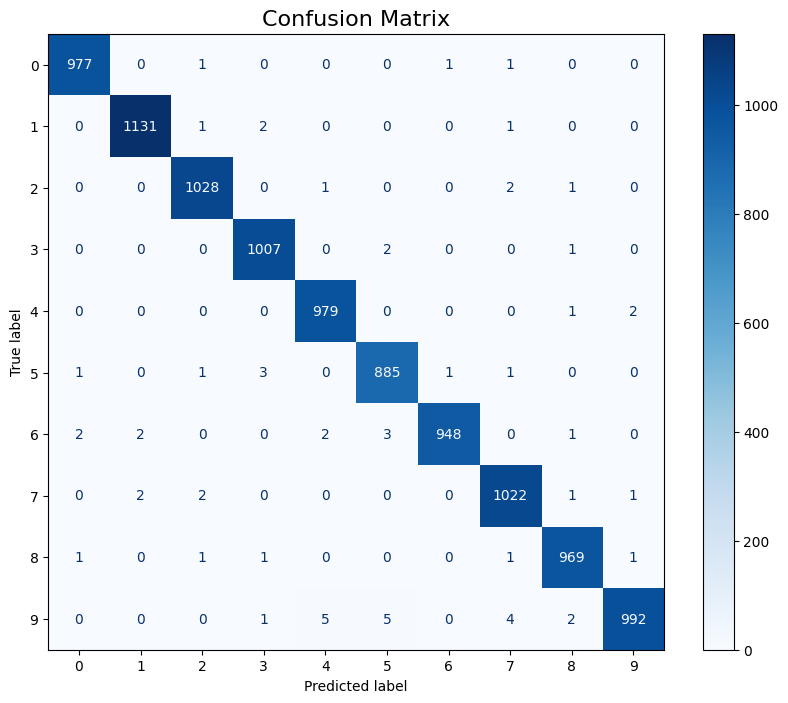

In [143]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis=-1)
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = pl.subplots(figsize=(10, 8))
disp.plot(cmap='Blues', ax=ax, values_format='d')
pl.title("Confusion Matrix", fontsize=16)
pl.show()